In [59]:
import timm
import torch
from tqdm import tqdm
import os

import wandb

import pandas as pd
import numpy as np

import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import Adam

from PIL import Image

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [60]:
MODEL_PATH = '/upstage-cv-classification-cv2/best_model.pth'
MODEL_NAME = 'efficientnet_b4'

VALID_CSV_PATH = '/upstage-cv-classification-cv2/data/valid.csv'
VALID_IMAGE_PATH = '/upstage-cv-classification-cv2/data/valid'

PROJECT_NAME = 'PatchModel_analyze'

META_CSV_PATH = '/upstage-cv-classification-cv2/data/meta.csv'

In [61]:
meta = pd.read_csv(META_CSV_PATH)

translations = {
        'account_number': '계좌번호',
        'application_for_payment_of_pregnancy_medical_expenses': '건강보험 임신출산 진료비 지급 신청서',
        'car_dashboard': '자동차 계기판',
        'confirmation_of_admission_and_discharge': '입퇴원 확인서',
        'diagnosis': '진단서',
        'driver_lisence': '운전면허증',
        'medical_bill_receipts': '진료비영수증',
        'medical_outpatient_certificate': '통원진료 확인서',
        'national_id_card': '주민등록증',
        'passport': '여권',
        'payment_confirmation': '진료비 납입 확인서',
        'pharmaceutical_receipt': '약제비 영수증',
        'prescription': '처방전',
        'resume': '이력서',
        'statement_of_opinion': '소견서',
        'vehicle_registration_certificate': '자동차 등록증',
        'vehicle_registration_plate': '자동차 번호판'
}

meta['kr_class_name'] = meta['class_name'].map(lambda x : translations[x])
meta

,target,class_name,kr_class_name
0,0,account_number,계좌번호
1,1,application_for_payment_of_pregnancy_medical_e...,건강보험 임신출산 진료비 지급 신청서
2,2,car_dashboard,자동차 계기판
3,3,confirmation_of_admission_and_discharge,입퇴원 확인서
4,4,diagnosis,진단서
5,5,driver_lisence,운전면허증
6,6,medical_bill_receipts,진료비영수증
7,7,medical_outpatient_certificate,통원진료 확인서
8,8,national_id_card,주민등록증
9,9,passport,여권


# 모델 로드

In [62]:
model = timm.create_model(MODEL_NAME, pretrained=False, num_classes=17).to(device)

# 모델 가중치 로드
model.load_state_dict(torch.load(MODEL_PATH))

/tmp/ipykernel_341062/2802445694.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))


<All keys matched successfully>

# 모델 성능 확인

In [63]:
# training config
img_size = 380
LR = 1e-3
BATCH_SIZE = 32

patience = 5
min_delta = 0.001 # 성능 개선의 최소 변화량

# test image 변환
data_transform = A.Compose([
    A.Resize(height = img_size, width = img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
    ToTensorV2()
])

class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image = img)['image']
    
        return img, target, name

    def get_labels(self):
        return self.df[:, 1] 

In [64]:
val_dataset = ImageDataset(
    VALID_CSV_PATH,
    VALID_IMAGE_PATH,
    transform = data_transform
)

val_loader = DataLoader(
    val_dataset,
    batch_size = BATCH_SIZE,
    num_workers = 0,
    pin_memory = True,
    drop_last = False
)

In [65]:
preds_list = []
targets_list = []
ids = []

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = LR)

model.eval()

with torch.no_grad():
    pbar = tqdm(val_loader)
    for step, (image, targets, id) in enumerate(pbar):
        image = image.to(device)
        targets = targets.to(device)

        preds = model(image)
        loss = loss_fn(preds, targets)
    
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())
        ids.extend(id)

        pbar.set_description(f"Loss: {loss.item():.4f}")



Loss: 0.0158: 100%|██████████| 10/10 [00:01<00:00,  6.49it/s]


In [66]:
result_df = pd.DataFrame()
result_df['id'] = ids
result_df['pred'] = preds_list
result_df['target'] = targets_list

result_df['pred_kr'] = result_df['pred'].map(lambda x : meta.loc[meta['target'] == x, 'kr_class_name'].values[0])
result_df['target_kr'] = result_df['target'].map(lambda x : meta.loc[meta['target'] == x, 'kr_class_name'].values[0])

result_df

,id,pred,target,pred_kr,target_kr
0,valid_d919dabe9f066dfc.jpg,1,1,건강보험 임신출산 진료비 지급 신청서,건강보험 임신출산 진료비 지급 신청서
1,valid_7f23b9ae37e539ea.jpg,1,1,건강보험 임신출산 진료비 지급 신청서,건강보험 임신출산 진료비 지급 신청서
2,valid_9a36a151cf95bb29.jpg,1,1,건강보험 임신출산 진료비 지급 신청서,건강보험 임신출산 진료비 지급 신청서
3,valid_f0d11155d48758de.jpg,1,1,건강보험 임신출산 진료비 지급 신청서,건강보험 임신출산 진료비 지급 신청서
4,valid_c8816965abf6559b.jpg,1,1,건강보험 임신출산 진료비 지급 신청서,건강보험 임신출산 진료비 지급 신청서
...,...,...,...,...,...
291,valid_1421fb31607c5123.jpg,13,13,이력서,이력서
292,valid_70ee60fe819b7b39.jpg,0,0,계좌번호,계좌번호
293,valid_359fab2e1b0ab5e1.jpg,2,2,자동차 계기판,자동차 계기판
294,valid_01385f22f2490868.jpg,4,4,진단서,진단서


In [67]:
print("Classification Report:")
report = classification_report(targets_list, preds_list, target_names=[str(i) for i in range(17)])
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        20
           3       0.64      0.58      0.61        12
           4       0.73      0.94      0.82        17
           5       0.89      1.00      0.94        16
           6       1.00      0.90      0.95        29
           7       0.80      0.60      0.69        20
           8       0.94      0.94      0.94        16
           9       1.00      1.00      1.00        12
          10       0.80      1.00      0.89        20
          11       1.00      0.85      0.92        13
          12       0.95      0.91      0.93        22
          13       1.00      0.94      0.97        17
          14       0.93      0.93      0.93        14
          15       1.00      1.00      1.00        19
          16       1.00      1.00      1.00        16

   

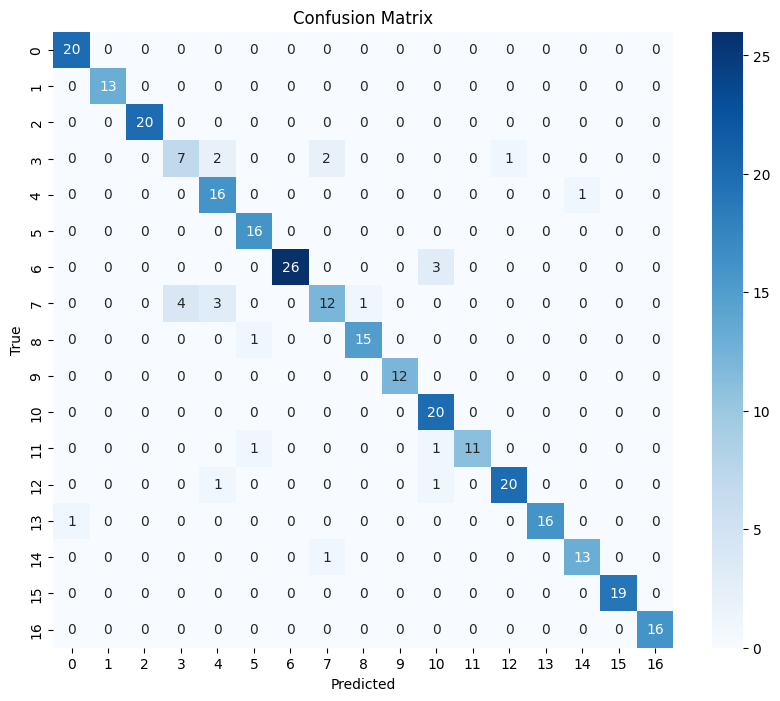

In [68]:
cm = confusion_matrix(targets_list, preds_list)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
plt.close()

# wandb 시각화

In [69]:
wandb.init(project=PROJECT_NAME)

wandb.log({"classification_report" : wandb.Html(f"<pre>{report}</pre>")})

In [70]:
wandb_images = {"wrong" : [],
                "target 0" : [],
                "target 1" : [],
                "target 2" : [],
                "target 3" : [],
                "target 4" : [],
                "target 5" : [],
                "target 6" : [],
                "target 7" : [],
                "target 8" : [],
                "target 9" : [],
                "target 10" : [],
                "target 11" : [],
                "target 12" : [],
                "target 13" : [],
                "target 14" : [],
                "target 15" : [],
                "target 16" : [],}

for id, pred, target, pred_kr, target_kr in result_df.itertuples(index=False):
    image_np = np.array(Image.open(os.path.join(VALID_IMAGE_PATH, id)).resize((224, 224), Image.LANCZOS))
    image = wandb.Image(image_np, caption=f"실제 : {target_kr}({target}), 예측 : {pred_kr}({pred})")

    wandb_images[f"target {target}"].append(image)
    
    if target != pred:
        wandb_images["wrong"].append(image)

wandb.log(wandb_images)

In [72]:
wandb.finish()